In [1]:
from subgraph import *
import networkx as nx

c:\Users\56984\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
hop = 3

task_dir = './dataset/YAGO3-10'
loader = DataLoader(task_dir, 1)

n_ent, n_rel = loader.graph_size()

train_data = loader.load_data('train')
valid_data = loader.load_data('valid')
test_data = loader.load_data('test')
adj_list = []
triplets = []
for i in range(len(train_data[0])):
    triplets.append([train_data[0][i], train_data[1][i], train_data[2][i]])
triplets = np.array(triplets)
for i in range(n_rel):
    idx = np.argwhere(triplets[:, 2] == i)
    adj_list.append(csc_matrix((np.ones(len(idx), dtype=np.uint8),
                                (triplets[:, 0][idx].squeeze(1), triplets[:, 1][idx].squeeze(1))),
                                shape=(n_ent, n_ent)))

n1 = 1
n2 = 4

nodes, n_labels, subgraph_size, enc_ratio, num_pruned_nodes = subgraph_extraction_labeling((n1, n2), adj_list, hop, True, None)
a = 0

The toolkit is importing datasets.

The total of relations is 37
The total of entities is 123182


In [3]:
adj_weight_list = []
for i in range(n_rel):
    idx = np.argwhere(triplets[:, 2] == i)
    adj_weight_list.append(csc_matrix((np.full(len(idx),fill_value=i, dtype=np.uint8),
                                (triplets[:, 0][idx].squeeze(1), triplets[:, 1][idx].squeeze(1))),
                                shape=(n_ent, n_ent)))

In [7]:
def incidence_matrix_weight1(adj_list):
    '''
    adj_list: List of sparse adjacency matrices
    '''

    rows, cols, dats = [], [], []
    dim = adj_list[0].shape
    for adj in adj_list:
        adjcoo = adj.tocoo()
        rows += adjcoo.row.tolist()
        cols += adjcoo.col.tolist()
        dats += adjcoo.data.tolist()
    row = np.array(rows)
    col = np.array(cols)
    data = np.array(dats)
    temp_m =  ssp.csc_matrix((data, (row, col)), shape=dim)
    adjcoo = temp_m.tocoo()
    rows = adjcoo.row.tolist()
    cols = adjcoo.col.tolist()
    row = np.array(rows)
    col = np.array(cols)
    data = np.ones(row.shape)
    return ssp.csc_matrix((data, (row, col)), shape=dim)

In [8]:

adj = incidence_matrix_weight1(adj_list)
adj = adj[nodes, :][:, nodes]
adj_weight_list = [m[nodes, :][:, nodes] for m in adj_weight_list]
adj.shape

(66004, 66004)

In [9]:
test_graph = nx.from_scipy_sparse_array(adj)

In [34]:
def get_relation_id(adj_list, node1, node2):
    for i in range(len(adj_list)):
        if adj_list[i][node1,node2] >= 1:
            return i
    return -1

In [35]:
def get_muticenter(graph, adj_weight_list, centers, max_graph_num):
    centers_graphs = []
    routes = [[]]
    for i in range(len(centers)):
        for j in range(i + 1, len(centers)):
            new_routes = []
            for route in routes:
                if nx.has_path(graph, centers[i], centers[j]):
                    for k, path in enumerate(nx.shortest_simple_paths(graph, centers[i], centers[j])):
                        if k >= max_graph_num:
                            break
                        new_routes.append(route + path)

                if nx.has_path(graph, centers[j], centers[i]):
                    for k, path in enumerate(nx.shortest_simple_paths(graph, centers[j], centers[i])):
                        if k >= max_graph_num:
                            break
                        new_routes.append(route + path)
            routes = new_routes
    for i, route in enumerate(routes):
        if i >= max_graph_num:
            break
        sub_graph = nx.MultiDiGraph()
        for i in range(len(route)-1):
            sub_graph.add_edge(route[i], route[i+1], weight=get_relation_id(adj_weight_list, route[i], route[i+1]))
        centers_graphs.append(sub_graph)
    return centers_graphs

In [88]:
centers_graphs = get_muticenter(test_graph, adj_weight_list, [0, 1], max_graph_num=2)

In [95]:
def breadFirstGraphExtract(graph, sub_graph, adj_weight_list, relation, max_depth, max_entity_num):
    if max_entity_num <= 0:
        return sub_graph
    que = []  # entity, depth
    for node in sub_graph.nodes:
        que.append((node, 1))
    while que:
        temp_tuple = que.pop(0)
        temp_entity, temp_depth = temp_tuple[0], temp_tuple[1]
        if nx.number_of_nodes(sub_graph) >= max_entity_num:
            return sub_graph
        if temp_depth >= max_depth:
            continue
        for n in graph.adj[temp_entity].keys():
            rel_ = get_relation_id(adj_weight_list, temp_entity, n)
            if rel_ in relation:
                sub_graph.add_edge(temp_entity, n, weight=rel_)
                que.append((n, temp_depth+1))
            if nx.number_of_nodes(sub_graph) >= max_entity_num:
                return sub_graph
    return sub_graph
def deepFirstGraphExtract(graph, sub_graph, adj_weight_list, relation, max_depth, max_entity_num):
    if max_entity_num <= 0:
        return sub_graph
    stack = []  # entity, depth
    for node in sub_graph.nodes:
        stack.append((node, 1))
    while stack:
        temp_tuple = stack.pop()
        temp_entity, temp_depth = temp_tuple[0], temp_tuple[1]
        if nx.number_of_nodes(sub_graph) >= max_entity_num:
            return sub_graph
        if temp_depth >= max_depth:
            continue
        for n in graph.adj[temp_entity].keys():
            rel_ = get_relation_id(adj_weight_list, temp_entity, n)
            if rel_ in relation:
                sub_graph.add_edge(temp_entity, n, weight=rel_)
                stack.append((n, temp_depth+1))
            if nx.number_of_nodes(sub_graph) >= max_entity_num:
                return sub_graph
    return sub_graph

In [96]:
sub_graph = deepFirstGraphExtract(test_graph, centers_graphs[0], adj_weight_list,list(range(30)), 3, 10)

In [97]:
nx.number_of_nodes(centers_graphs[0])

10

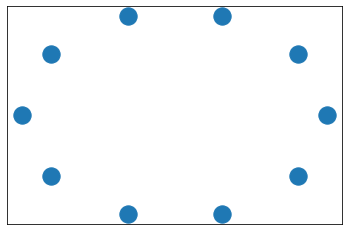

In [98]:
pos = nx.circular_layout(sub_graph)
nx.draw_networkx_nodes(sub_graph, pos)

In [106]:
G = nx.Graph()
G.add_edge(1, 2)
nx.get_node_attributes(G, 'name')


{}

In [ ]:
def get_muticenter(graph, centers, max_graph_num):
    centers_graphs = []
    routes = [[]]
    for i in range(len(centers)):
        for j in range(i + 1, len(centers)):
            new_routes = []
            for route in routes:
                if nx.has_path(graph, centers[i], centers[j]):
                    for path in nx.all_simple_edge_paths(graph, centers[i], centers[j]):
                        new_routes.append(route + path)
                if nx.has_path(graph, centers[j], centers[i]):
                    for path in nx.all_simple_edge_paths(graph, centers[j], centers[i]):
                        new_routes.append(route + path)
            routes = new_routes
    for i, route in enumerate(routes):
        if i >= max_graph_num:
            break
        sub_graph = nx.MultiDiGraph()
        for edge in route:
            sub_graph.add_edge(edge[0], edge[1], edge[2], weight=graph.edges[tuple(edge)]['weight'])
        centers_graphs.append(sub_graph)
    return centers_graphs

In [63]:
for i, path in enumerate(nx.shortest_simple_paths(test_graph, 1, 4)):
    if i > 3:
        break
    print(path)

[1, 933, 56944, 4]
[1, 1307, 56944, 4]
[1, 2684, 56944, 4]
[1, 7366, 56944, 4]


In [47]:
test_muticenter = get_muticenter(test_graph, [1,4], 2)

KeyboardInterrupt: 

In [7]:
print(subgraph_size)
print(enc_ratio)
print(num_pruned_nodes)

66004
0.6585290600969644
221


In [24]:
import networkx as nx
from matplotlib import pyplot as plt
# In[52]:


def deepFirstGraphExtract(graph, sub_graph, relation, max_depth, max_entity_num):
    if max_entity_num <= 0:
        return sub_graph
    stack = []  # entity, depth
    for node in sub_graph.nodes:
        stack.append((node, 1))
    while stack:
        temp_tuple = stack.pop()
        temp_entity, temp_depth = temp_tuple[0], temp_tuple[1]
        if nx.number_of_nodes(sub_graph) >= max_entity_num:
            return sub_graph
        if temp_depth >= max_depth:
            continue
        print(temp_entity)
        for n, nbrs in graph.adj[temp_entity].items():
            for nbr, edict in nbrs.items():
                if edict['weight'] == relation and n not in sub_graph.nodes:
                    sub_graph.add_edge(temp_entity, n, weight=relation)
                    stack.append((n, temp_depth + 1))
    return sub_graph


# In[53]:


def breadFirstGraphExtract(graph, sub_graph, relation, max_depth, max_entity_num):
    if max_entity_num <= 0:
        return sub_graph
    que = []  # entity, depth
    for node in sub_graph.nodes:
        que.append((node, 1))
    while que:
        temp_tuple = que.pop(0)
        temp_entity, temp_depth = temp_tuple[0], temp_tuple[1]
        if nx.number_of_nodes(sub_graph) >= max_entity_num:
            return sub_graph
        if temp_depth >= max_depth:
            continue
        for n, nbrs in graph.adj[temp_entity].items():
            for nbr, edict in nbrs.items():
                if edict['weight'] == relation and n not in sub_graph.nodes:
                    sub_graph.add_edge(temp_entity, n, weight=relation)
                    que.append((n, temp_depth + 1))
    return sub_graph


# Define function for reading txt file and skip first line, txt content split as tab
def get_data(file, encoding='gbk'):
    res = []
    with open(file, 'r', encoding=encoding) as f:
        next(f)
        for line in f:
            l = line.split()
            l[0], l[1] = l[1], l[0]
            tl = tuple(l)
            res.append(tl)
    return res


# # path of txt files
# entity = r'./dataset/entity2id.txt'
# relate = r'./dataset/relation2id.txt'
# train = r'./dataset/train2id.txt'
#
# # txt to Dataframe
# pts = get_data(entity)
# relates = get_data(relate)
# weight = [w[2] for w in get_data(train)]





# get the relationships
def get_relation(file, encoding='gbk'):
    res = []
    with open(file, 'r', encoding=encoding) as f:
        next(f)
        for line in f:
            d = line.split()
            d[0] = replace_label(d[0])
            d[1] = replace_label(d[1])
            # d[2] = int(d[2])
            dt = tuple(d)
            res.append(dt)
    return res


# # Draw Graph
# node = [n[1] for n in pts]
# edge = get_relation(train)
# # create graph
# G = nx.MultiDiGraph()
# # G = nx.DiGraph()
# G.add_nodes_from(node)
# G.add_weighted_edges_from(edge)
#
# # modify the labels
# old_attrs = nx.get_edge_attributes(G, 'weight')
# attrs = {}
# for k, v in old_attrs.items():
#     attrs[(k[0], k[1])] = v
# # rs == relationship
# for key, value in attrs.items():
#     attrs[key] = {"rs": replace_relate(value)}


# nx.set_edge_attributes(G, edge_labels)
# labels = nx.get_edge_attributes(G, 'relation')
# layout setting
# pos = nx.circular_layout(G)
# node
# plt.figure(dpi=300,figsize=(24,8))
# nx.draw_networkx_nodes(G, pos, node_size=400, node_color='#6495ED')
# label_options = {"ec": "k", "fc": "white", "alpha": 0.5}
# nx.draw_networkx_labels(G, pos, font_size=9, bbox=label_options)
# # edge
# nx.draw_networkx_edges(G, pos)
# # nx.draw_networkx_edges(G, pos, width=weight)
# # nx.draw_networkx_edges(G, pos, arrowstyle="->", arrowsize=10)
# print(attrs)
# nx.draw_networkx_edge_labels(G, pos, edge_labels=attrs)
# plt.axis('off')
# plt.show()


# In[28]:


def draw_sub(sub):

    def replace_relate(name):
        return dict(relates)[name]

    old_attrs = nx.get_edge_attributes(sub, 'weight')
    attrs = {}
    for k, v in old_attrs.items():
        attrs[(k[0], k[1])] = v
    # rs == relationship
    for key, value in attrs.items():
        attrs[key] = replace_relate(value)
    pos = nx.circular_layout(sub)
    # node
    plt.figure(dpi=100, figsize=(12, 8))
    nx.draw_networkx_nodes(sub, pos, node_size=400, node_color='#6495ED')
    label_options = {"ec": "k", "fc": "white", "alpha": 0.5}
    nx.draw_networkx_labels(sub, pos, font_size=9, bbox=label_options)
    # edge
    nx.draw_networkx_edges(sub, pos)
    nx.draw_networkx_edge_labels(sub, pos, edge_labels=attrs)
    plt.axis('off')
    # plt.show()


# In[22]:


def get_muticenter(graph, centers, max_graph_num):
    centers_graphs = []
    routes = [[]]
    for i in range(len(centers)):
        for j in range(i + 1, len(centers)):
            new_routes = []
            for route in routes:
                if nx.has_path(graph, centers[i], centers[j]):
                    for path in nx.all_simple_edge_paths(graph, centers[i], centers[j]):
                        new_routes.append(route + path)
                if nx.has_path(graph, centers[j], centers[i]):
                    for path in nx.all_simple_edge_paths(graph, centers[j], centers[i]):
                        new_routes.append(route + path)
            routes = new_routes
    for i, route in enumerate(routes):
        if i >= max_graph_num:
            break
        sub_graph = nx.MultiDiGraph()
        for edge in route:
            sub_graph.add_edge(edge[0], edge[1], edge[2], weight=graph.edges[tuple(edge)]['weight'])
        centers_graphs.append(sub_graph)
    return centers_graphs

In [26]:
entity = r'./dataset/YAGO3-10/entity2id.txt'
relate = r'./dataset/YAGO3-10/relation2id.txt'
train = r'./dataset/YAGO3-10/train2id.txt'

# txt to Dataframe
pts = get_data(entity, encoding='utf-8')
relates = get_data(relate, encoding='utf-8')
weight = [w[2] for w in get_data(train, encoding='utf-8')]

# define function for replace node label

In [29]:
def replace_label(name):
    return dict(pts)[name]

def replace_relate(name):
    return dict(relates)[name]
nodes_set = set(nodes)
node = np.array([pts[i][1] for i in range(len(pts))])[nodes].tolist()

In [36]:
edge = get_relation(train)
edge = [ed for ed in edge if (ed[0] in nodes_set and ed[1] in nodes_set)]

KeyboardInterrupt: 

In [16]:
G = nx.MultiDiGraph()
G.add_nodes_from(node)
G.add_weighted_edges_from(edge)

# modify the labels
old_attrs = nx.get_edge_attributes(G, 'weight')
attrs = {}
for k, v in old_attrs.items():
    attrs[(k[0], k[1])] = v
# rs == relationship
for key, value in attrs.items():
    attrs[key] = {"rs": replace_relate(value)}

In [20]:
max_num = 2  # 最多的子图数
centers = get_muticenter(G, ['Nitin_Saxena', 'Peace_Prize_of_the_German_Book_Trade'], max_num)  # 3个中心节点
for i in range(len(centers)):
    res = breadFirstGraphExtract(G, centers[i], '8', 5, 5)  # 这里可以改成deapfirst， 5是最大深度，15是最大节点数
    draw_sub(centers[i])
    draw_sub(res)

NodeNotFound: Either source Nitin_Saxena or target Peace_Prize_of_the_German_Book_Trade is not in G